## Vehicle Detection and Tracking Project
The goals / steps of this project are the following:
* Perform a Histogram of Oriented Gradient (HOG) feature extraction on a labled training set of images and train a classifier (SVM or Decision Tree)
* Apply a color trnasform and append binned color features to the HOG feature vector
* Experiment training your classifier on HOG / color features only, and then on the combination of the tewo Note: for first two steps, don't forget to normaize your features and randomize a selection for training and testing
* Using a Decision Tree classifier, explore the feature importances and consider pruning or adding new features
* Implemnet a sliding window technique and use your trained classifier to search for vehicles in images.
* Estimate a bounding box for vehicles detected.
* Run your pipeline on a video stream and implement tracking to follow detected vehicles.
* Estimate distance and trajectory of detected vehicles.

## Step 1. make a list of images to read in

In [1]:
import os
import glob

basedir = 'vehicles/'
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+'/*'))
    
print('Number of Vehicle Images found:', len(cars))
with open("cars.txt", 'w') as f:
    for fn in cars:
        f.write(fn+'\n')
    
basedir = 'non-vehicles/'
image_types = os.listdir(basedir)
notcars= []
for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+'/*'))
print('Number of Non-Vehicle Images found:', len(notcars))
with open("notcars.txt", 'w') as f:
    for fn in notcars:
        f.write(fn+'\n')

Number of Vehicle Images found: 8792
Number of Non-Vehicle Images found: 8968


## Step 2. import modules and packages

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time 
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#Note: the last import is only valid for scikit-learn version >= 0.18
#for scikit-learn<= 0.18 use:
#from sklearn.cross_validation import train_test_split

## Step 3. define functions

3.1 Function to Draw Boxes

In [3]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

3.2 Function to search for template matches and return a list of bounding boxes

In [4]:
def find_matches(img, template_list):
    # Define an empty list to take bbox coords
    bbox_list = []
    # Define matching method
    # Other options include: cv2.TM_CCORR_NORMED', 'cv2.TM_CCOEFF', 'cv2.TM_CCORR',
    #         'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'
    method = cv2.TM_CCOEFF_NORMED
    # Iterate through template list
    for temp in template_list:
        # Read in templates one by one
        tmp = mpimg.imread(temp)
        # Use cv2.matchTemplate() to search the image
        result = cv2.matchTemplate(img, tmp, method)
        # Use cv2.minMaxLoc() to extract the location of the best match
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        # Determine a bounding box for the match
        w, h = (tmp.shape[1], tmp.shape[0])
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        # Append bbox position to list
        bbox_list.append((top_left, bottom_right))
        # Return the list of bounding boxes
    return bbox_list

3.3 Define a function that takes an image,nstart and stop positions in both x and y, window size (x and y dimensions), and overlap fraction (for both x and y). Returns a list of windows to search

In [5]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    if x_start_stop[0] == None: # If x and/or y start/stop positions not defined, set to image size
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
      
    xspan = x_start_stop[1] - x_start_stop[0] # Compute the span of the region to be searched  
    yspan = y_start_stop[1] - y_start_stop[0]
    
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0])) # Compute the number of pixels per step in x/y
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    nx_windows = np.int(xspan/nx_pix_per_step) - 1 # Compute the number of windows in x/y
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    
    window_list = [] # Initialize a list to append window positions to
    

    for ys in range(ny_windows): # Loop through finding x and y window positions
        for xs in range(nx_windows): # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
    
            window_list.append(((startx, starty), (endx, endy))) # Append window position to list
    
    return window_list # Return the list of windows to search

3.4 Define a function to compute color histogram features 

In [6]:
def color_hist(img, nbins=32):# bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

3.5 Define function to convert image to new color space and return feature vector

In [7]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

3.6 Define a function to return some characteristics of the dataset 

In [8]:
def data_look(car_list, notcar_list):
    data_dict = {}
    data_dict["n_cars"] = len(car_list) # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_notcars"] = len(notcar_list) # Define a key "n_notcars" and store the number of notcar images
    example_img = mpimg.imread(car_list[0]) # Read in a test image, either car or notcar
    data_dict["image_shape"] = example_img.shape # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["data_type"] = example_img.dtype # Define a key "data_type" and store the data type of the test image.
    # Return data_dict
    return data_dict

3.7 Define a function to return HOG features and visualization

In [9]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=False, feature_vector=feature_vec)
        
        return features

3.8 Define a function to extract features from a list of images. Have this function call bin_spatial() and color_hist()

In [10]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = [] # Create a list to append feature vectors to
    
    for file in imgs: # Iterate through the list of images
        file_features = []
        
        image = mpimg.imread(file) # Read in each one by one
        
        if color_space != 'RGB': # apply color conversion if other than 'RGB'
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        if hist_feat == True:  
            hist_features = color_hist(feature_image, nbins=hist_bins) # Apply color_hist()
            file_features.append(hist_features)
        
        if hog_feat == True:
            if hog_channel == 'ALL': # Call get_hog_features() with vis=False, feature_vec=True
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
            file_features.append(hog_features) # Append the new feature vector to the features list
        features.append(np.concatenate(file_features)) # Concatenante feature vectors into single list
    
    return features # Return list of feature vectors

3.9 Define a function to extract features from a single image window.

In [11]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis = False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))   
            hog_features = np.concatenate(hog_features)
        else:
            
            if vis == True:
                hog_features , hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
                
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                
        #8) Append features to list
        
        
        hog_features = np.ravel(hog_features)
        
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if hog_channel == 'All':
        return np.concatenate(img_features)
    else:
        if vis == True:
            return np.concatenate(img_features), hog_image
        else:
            return np.concatenate(img_features)

3.10 Define a function to pass an image and the list of windows to be searched (output of slide_windows())

In [12]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    
    on_windows = [] #1) Create an empty list to receive positive detection windows
    
    for window in windows: #2) Iterate over all windows in the list
        
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) #3) Extract the test window from original image
        
        features = single_img_features(test_img, color_space=color_space,  #4) Extract features for that window using single_img_features()
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
      
        test_features = scaler.transform(np.array(features).reshape(1, -1)) #5) Scale extracted features to be fed to classifier

        prediction = clf.predict(test_features) #6) Predict using classifier
        
        if prediction == 1: #7) If positive (prediction == 1) then save the window
            on_windows.append(window)
    
    return on_windows #8) Return windows for positive detections

3.11 Define function to create heatmap on the bounding boxes

In [13]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list: # Iterate through list of bboxes 
        # Add += 1 for all pixels inside each bbox. Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1  
    return heatmap # Return updated heatmap

3.12 Define function to apply threshold to the heatmap

In [14]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0 # Zero out pixels below the threshold
    return heatmap # Return thresholded map

3.13 Define function to draw labeled bounding boxes

In [15]:
def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1): # Iterate through all detected cars
        nonzero = (labels[0] == car_number).nonzero() # Find pixels with each car_number label value
        nonzeroy = np.array(nonzero[0]) # Identify x and y values of those pixels
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))) # Define a bounding box based on min/max x and y
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6) # Draw the box on the image
    return img # Return the image

3.14 Define function to visualize images

In [16]:
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

## Step 4. test pipeline on single image

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


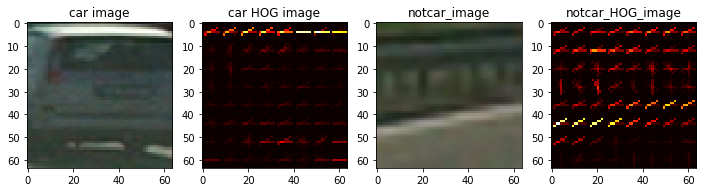

In [17]:
%matplotlib inline

car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

color_space = 'RGB'#'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
orient = 6 #9  # HOG orientations
pix_per_cell =8 # 4 # HOG pixels per cell                                                         
cell_per_block = 2 #4 # HOG cells per block
hog_channel =  0#"ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16,16) #(64, 64) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat =  True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis =  True)

notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis = True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar_image', 'notcar_HOG_image']
fig = plt.figure(figsize=(12,3))#,dpi=80)
visualize(fig, 1, 4, images, titles)

## Step 4. Train Classifier

In [19]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 # 9 # HOG orientations
pix_per_cell =8 # 4 # HOG pixels per cell                                                         
cell_per_block = 2 #4 # HOG cells per block
hog_channel =  "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32,32) #(64, 64) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat =  True # Histogram features on or off
hog_feat = True # HOG features on or off


t=time.time()
n_samples =1000
random_idxs = np.random.randint(0, len(cars), n_samples)
test_cars = cars       ####np.array(cars)[random_idxs]
test_notcars = notcars    #####np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t, 'Seconds to complete features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64) 

X_scaler = StandardScaler().fit(X) # Fit a per-column scaler

scaled_X = X_scaler.transform(X) # Apply the scaler to X


y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) # Define the labels vector

rand_state = np.random.randint(0, 100) # Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

svc = LinearSVC() # Use a linear SVC 

t=time.time() # Check the training time for the SVC
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')

print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC

t=time.time() # Check the prediction time for a single sample

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


91.17611122131348 Seconds to complete features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
7.98 Seconds to train SVC...
Test Accuracy of SVC =  0.9901


## Step 6. Train Classifier On Example Files

In [20]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [400, 656]
overlap = 0.5

for img_src in example_images:
    t1 = time.time()
    img =mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255  # .jpeg scale 0 to 255  .png scale 0 to 1
    print(np.min(img), np.max(img))
    
    windows_1 = slide_window(img, x_start_stop=[None, None], y_start_stop= y_start_stop,
                          xy_window= (128, 128), xy_overlap= (overlap, overlap))     

    windows = windows_1 
        
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                    spatial_size=spatial_size,
                    hist_bins=hist_bins, orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat= hist_feat, hog_feat=hog_feat)
    
    window_img = draw_boxes(draw_img, hot_windows, color = (0,0,255), thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to process one image searching', len(windows), 'windows')

fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 5, 2, images, titles)

0.0 1.0


/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.37552404403686523 seconds to process one image searching 57 windows
0.0 1.0
0.2865750789642334 seconds to process one image searching 57 windows
0.0 1.0
0.2562229633331299 seconds to process one image searching 57 windows
0.0 1.0
0.3035550117492676 seconds to process one image searching 57 windows
0.0 1.0
0.3374440670013428 seconds to process one image searching 57 windows
0.0 1.0
0.25527095794677734 seconds to process one image searching 57 windows


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [21]:
def convert_color(img, conv = "RGB2YCrCb"):
    if conv == "RGB2YCrCb":
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == "BGR2YCrCb":
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == "RGB2LUV":
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

## Step 7. Process Heatmap

(256, 1280, 3)


/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.8887958526611328 second to run, total windows =  912
(256, 1280, 3)
0.9649491310119629 second to run, total windows =  912
(256, 1280, 3)
0.8314599990844727 second to run, total windows =  912
(256, 1280, 3)
0.9716131687164307 second to run, total windows =  912
(256, 1280, 3)
0.8231260776519775 second to run, total windows =  912
(256, 1280, 3)
0.9660279750823975 second to run, total windows =  912


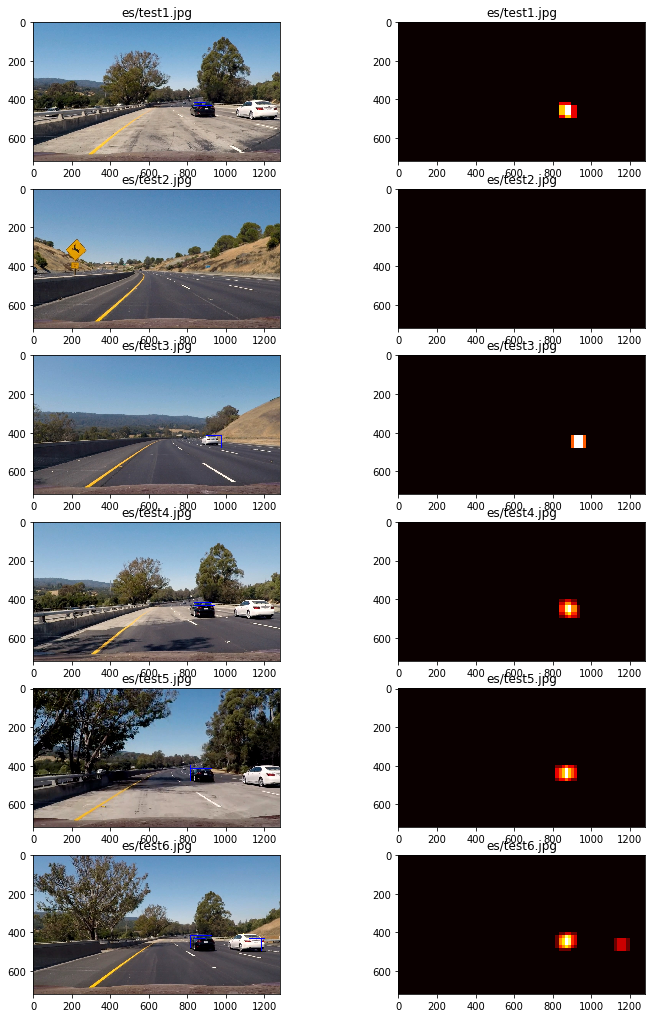

In [23]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []

ystart = 400 #Consider a narrower swath in y
ystop = 656
scale = 1 #1.5 # 2 is 128

for img_src in example_images: #Iterate over test images
    img_boxes= []
    t=time.time()
    count=0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    
    heatmap = np.zeros_like(img[:,:,0]) #Make a heatmap of zeros
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale !=1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    print(ctrans_tosearch.shape)

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2] 
    
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1 #Define blocks and steps for the channel
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block **2
    
    window =64
    
    nblocks_per_window = (window // pix_per_cell) -1
    cells_per_step = 2 #Instead of overlap , define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)      
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count +=1 
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            #Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            #Get color features
            spatial_features = bin_spatial(subimg, size= spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            #Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart),(0,0,255))
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
    print(time.time()-t, 'second to run, total windows = ', count)
    out_images.append(draw_img)
    out_titles.append(img_src[-12:])
    out_titles.append(img_src[-12:])

    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)

    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2,out_images, out_titles)

## Step 8. Create Pipeline Function

In [24]:

def find_cars(img, scale): #Iterate over test images
    count = 0
    draw_img = np.copy(img)
    
    heatmap = np.zeros_like(img[:,:,0]) #Make a heatmap of zeros
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale !=1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2] 

    
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1 #Define blocks and steps for channel
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block **2

    window =64

    nblocks_per_window = (window // pix_per_cell) -1
    cells_per_step = 2 #Instead of overlap , define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)      
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            count +=1 
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            #Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)) #Stack channels to for full list of hog features

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            #Get color features
            spatial_features = bin_spatial(subimg, size= spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            #Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart),(0,0,255))
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
            
            
            H.n_maps.append(heatmap)
            if len(H.n_maps) > n:
                H.n_maps = H.n_maps[1:]
                
                temp = []

    return draw_img, heatmap

In [25]:
n= 5
class Heatmaps():
    def __init__(self):

        self.n_maps = []

In [26]:
H = Heatmaps()

In [27]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    heatmap[heatmap<=threshold] = 0 # Zero out pixels below the threshold
    return heatmap # Return thresholded map

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1): # Iterate through all deteched cars
        nonzero = (labels[0] == car_number).nonzero()  # Find pixels with each car_number label
        nonzeroy = np.array(nonzero[0]) # Identify x and y values of those pixels
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))) #Define a bounding box based on min/max x and y
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6) # Draw the box on the image
    
    return img # Return the image

## Process Test Images w/ Heatmap

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


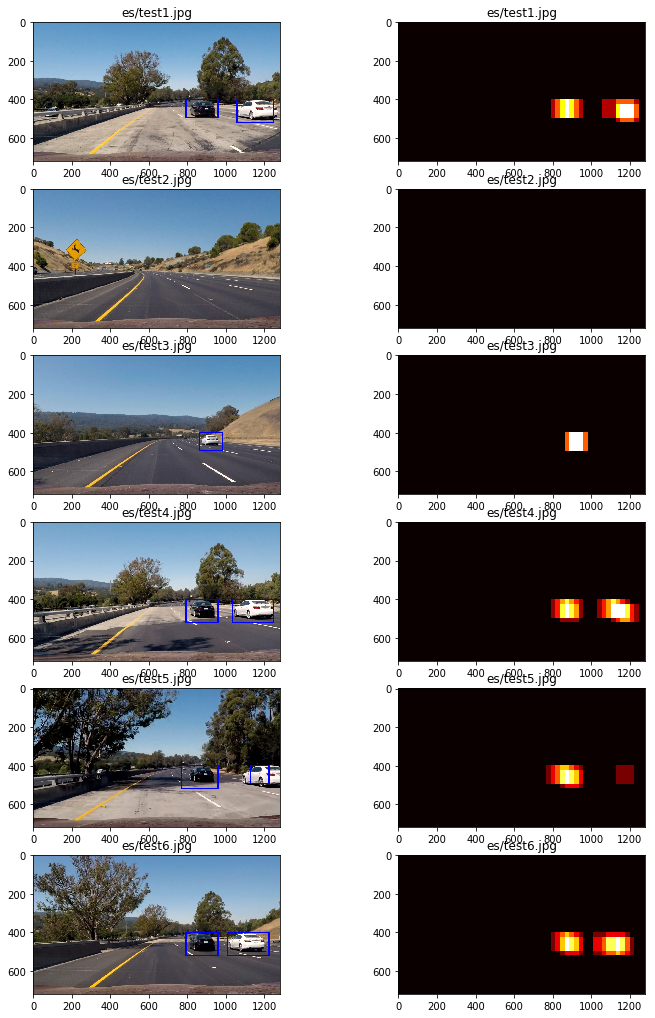

In [28]:
out_images = []
out_maps = []
#out_titles = []
#out_boxes = []
ystart = 400
ystop = 656
scale = 1.5

for img_src in example_images: #Iterate over test images
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels) # Draw bounding boxes on a copy of the image
    out_images.append(draw_img)
    out_images.append(heat_map)
    
fig= plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [29]:
def process_image(img):
    out_img, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels) # Draw bounding boxes on a copy of the image
    return draw_img

In [30]:
#Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#Uncomment one of the following 3
test_video = VideoFileClip('test_video.mp4')
test_video_output = 'test_video_output.mp4'
clip = VideoFileClip("test_video.mp4")

#challenge_video = VideoFileClip('challenge_video.mp4')
#challenge_video_output = 'challenge_video_output.mp4'
#clip = VideoFileClip("challenge_video.mp4")

#harder_challenge_video = VideoFileClip('harder_challenge_video.mp4')
#harder_challenge_video_output = 'harder_challenge_video_output.mp4'
#clip = VideoFileClip('harder_challenge_video.mp4')

#Uncomment one of the following 3
test_video_clip = clip.fl_image(process_image)  #NOTE: this function expects color images!!
%time test_video_clip.write_videofile(test_video_output, audio=False)

#project_video_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
#%time project_video_clip.write_videofile(challenge_video_output, audio=False)

#project_video_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
#%time project_video_clip.write_videofile(harder_challenge_video_output, audio=False)

#.format(project_video_output))
#.format(challenge_video_output))
#.format(harder_challenge_video_output))

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_video_output))

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:11<00:00,  3.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 11.4 s, sys: 732 ms, total: 12.1 s
Wall time: 12.4 s


In [31]:
#Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#Uncomment one of the following 3
project_video = VideoFileClip('project_video.mp4')
project_video_output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")

#challenge_video = VideoFileClip('challenge_video.mp4')
#challenge_video_output = 'challenge_video_output.mp4'
#clip = VideoFileClip("challenge_video.mp4")

#harder_challenge_video = VideoFileClip('harder_challenge_video.mp4')
#harder_challenge_video_output = 'harder_challenge_video_output.mp4'
#clip = VideoFileClip('harder_challenge_video.mp4')

#Uncomment one of the following 3
project_video_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)

#project_video_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
#%time project_video_clip.write_videofile(challenge_video_output, audio=False)

#project_video_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
#%time project_video_clip.write_videofile(harder_challenge_video_output, audio=False)

#.format(project_video_output))
#.format(challenge_video_output))
#.format(harder_challenge_video_output))

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:35<00:00,  3.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 6min 23s, sys: 21.6 s, total: 6min 45s
Wall time: 6min 36s
